# Interpolating fields from the model llc grid to a regular lat lon grid


## Objectives

1. Learn how to interpolate scalar and vector fields from ECCOv4's lat-lon-cap 90 (llc90) model grid to the more common regular latitude-longitude grid.  

2. Learn how to save these interpolated fields as netCDF for later analysis 

## Introduction

Recall the orientations of the 13 tiles of the ECCOv4 native llc90 model grid.

![llc90 tile layout](../figures/llc90_0.png)

Tiles 7-12 are rotated 90 degrees counter-clockwise relative to tiles 0-5.

In this tutorial we demonstrate two methods for mapping scalar and vector fields from the llc90 model grid to "regular" latitude-longitude grids of arbitrary resolution.  

> **Note:**  *There are many methods on can use to map between the grids (e.g., nearest neighbor, bilinear interpolation, bin-averaging, etc.), each with its own advantages.)*

In this tutorial we'll use the ECCO grid file and monthly SSH and wind stress from the year 2000. If you don't have them all downloaded already, the ShortNames of the datasets are:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4**
- **ECCO_L4_STRESS_LLC0090GRID_MONTHLY_V4R4**


## How to interpolate scalar ECCO fields to a lat-lon grid

Scalar fields are the most straightforward fields to interpolate.

### Preliminaries: Load fields

First, let's load the all 13 tiles for sea surface height and the model grid parameters.

In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

In [2]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [4]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [5]:
## Load monthly SSH from 2000
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*SSH*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

pprint(ecco_ds.data_vars)

Data variables:
    CS        (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN        (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    rA        (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    dxG       (tile, j_g, i) float32 1.558e+04 1.559e+04 ... 2.36e+04 2.314e+04
    dyG       (tile, j, i_g) float32 2.321e+04 2.327e+04 ... 1.56e+04 1.558e+04
    Depth     (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rAz       (tile, j_g, i_g) float32 1.799e+08 1.805e+08 ... 3.642e+08
    dxC       (tile, j, i_g) float32 1.558e+04 1.559e+04 ... 2.387e+04 2.341e+04
    dyC       (tile, j_g, i) float32 1.156e+04 1.159e+04 ... 1.559e+04 1.558e+04
    rAw       (tile, j, i_g) float32 3.617e+08 3.628e+08 ... 3.722e+08 3.648e+08
    rAs       (tile, j_g, i) float32 1.802e+08 1.807e+08 ... 3.678e+08 3.605e+08
    drC       (k_p1) float32 5.0 10.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.2
    drF       (k) float32 10.

### Plotting the dataset

Plotting the ECCOv4 fields was covered in an earlier tutorial.  Before demonstrating interpolation, we will first plot one of our SSH fields. Take a closer look at the arguments of ``plot_proj_to_latlon_grid``, ``dx=2`` and ``dy=2``.

-179.0 179.0
-180.0 180.0
-89.0 89.0
-90.0 90.0


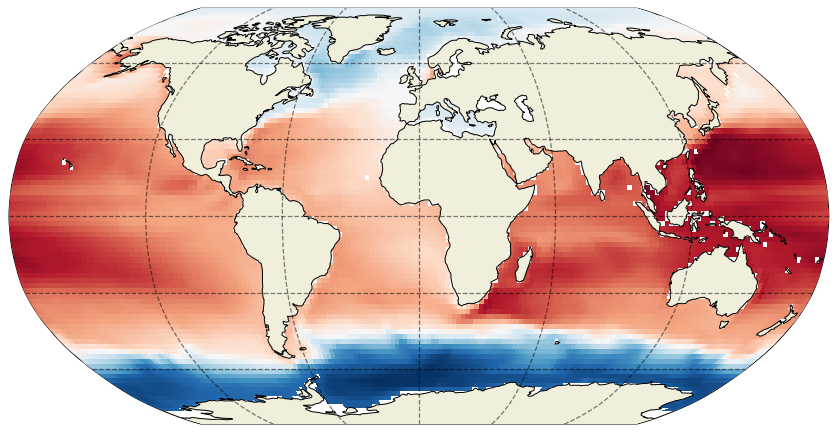

In [6]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                              ecco_ds.YC, \
                              tmp_plt, \
                              plot_type = 'pcolormesh', \
                              dx=2,\
                              dy=2, \
                              projection_type = 'robin',\
                              less_output = True);


These ``dx`` and ``dy`` arguments tell the plotting function to interpolate the native grid tiles onto a lat-lon grid with spacing of ``dx`` degrees longitude and ``dy`` degrees latitude.  If we reduced ``dx`` and ``dy`` the resulting map would have finer features: Compare with the map when ``dx``=``dy``=0.25 degrees:

-179.875 179.875
-180.0 180.0
-89.875 89.875
-90.0 90.0


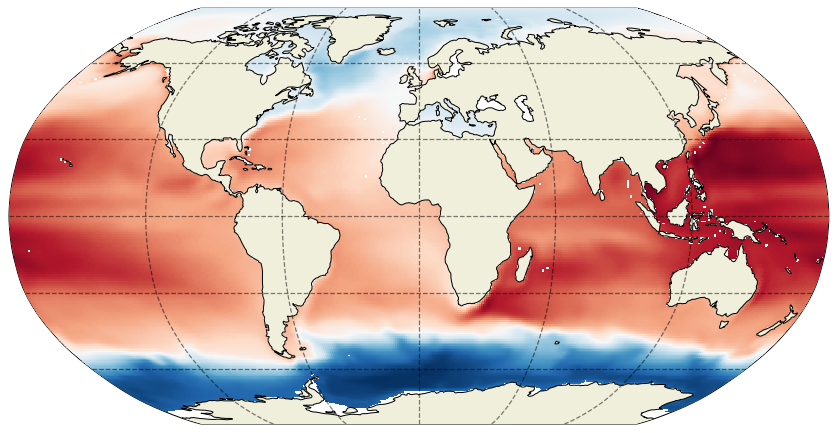

In [7]:
plt.figure(figsize=(12,6), dpi= 90)

tmp_plt = ecco_ds.SSH.isel(time=1)
tmp_plt = tmp_plt.where(ecco_ds.hFacC.isel(k=0) !=0)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, \
                              ecco_ds.YC, \
                              tmp_plt, \
                              plot_type = 'pcolormesh', \
                              dx=0.25,\
                              dy=0.25, \
                              projection_type = 'robin',\
                              less_output = True);


Of course you can interpolate to arbitrarily high resolution lat-lon grids, the model resolution will ultimately determine the smallest resolvable features. 

Under the hood of ``plot_proj_to_lat_longrid`` is a call to the very useful routine ``resample_to_latlon`` which is the now described in more detail

## resample_to_latlon

``resample_to_latlon`` takes a field with a cooresponding set of lat lon coordinates (the *source* grid) and interpolates to a new lat-lon *target* grid.  The arrangement of coordinates in the *source* grid is arbitrary. One also provides the $bounds$ of the new lat lon grid.  The example shown above uses -90..90N and -180..180E by default.  In addition, one specifies which interpolation scheme to use (*mapping method*) and the *radius of influence*, the radius around the *target* grid cells within which to search for values from the *source* grid.   

In [8]:
help(ecco.resample_to_latlon)

Help on function resample_to_latlon in module ecco_v4_py.resample_to_latlon:

resample_to_latlon(orig_lons, orig_lats, orig_field, new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat, new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon, radius_of_influence=120000, fill_value=None, mapping_method='bin_average')
    Take a field from a source grid and interpolate to a target grid.
    
    Parameters
    ----------
    orig_lons, orig_lats, orig_field : xarray DataArray or numpy array  :
        the lons, lats, and field from the source grid
    
        new_grid_min_lat, new_grid_max_lat : float
                latitude limits of new lat-lon grid
    
    new_grid_delta_lat : float
        latitudinal extent of new lat-lon grid cells in degrees (-90..90)
    
    new_grid_min_lon, new_grid_max_lon : float
                longitude limits of new lat-lon grid (-180..180)
    
    new_grid_delta_lon : float
         longitudinal extent of new lat-lon grid cells in degrees
    
    ra

## Demonstrations of  ``resample_to_latlon``

### Global
First we will map to a global lat-lon grid at 1degree using nearest neighbor

In [9]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                ecco_ds.SSH.isel(time=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

-179.5 179.5
-180.0 180.0
-89.5 89.5
-90.0 90.0


In [10]:
# Dimensions of the new grid:
pprint(new_grid_lat_centers.shape)
pprint(new_grid_lon_centers.shape)

(180, 360)
(180, 360)


In [11]:
pprint(new_grid_lon_centers)

# the second dimension of new_grid_lon has the center longitude of the new grid cells
pprint(new_grid_lon_centers[0,0:10])

array([[-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       ...,
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5],
       [-179.5, -178.5, -177.5, ...,  177.5,  178.5,  179.5]])
array([-179.5, -178.5, -177.5, -176.5, -175.5, -174.5, -173.5, -172.5,
       -171.5, -170.5])


In [12]:
# The set of lat points
pprint(new_grid_lat_centers)

# or as a 1D vector
# the first dimension of new_grid_lat has the center latitude of the new grid cells
pprint(new_grid_lat_centers[0:10,0])

array([[-89.5, -89.5, -89.5, ..., -89.5, -89.5, -89.5],
       [-88.5, -88.5, -88.5, ..., -88.5, -88.5, -88.5],
       [-87.5, -87.5, -87.5, ..., -87.5, -87.5, -87.5],
       ...,
       [ 87.5,  87.5,  87.5, ...,  87.5,  87.5,  87.5],
       [ 88.5,  88.5,  88.5, ...,  88.5,  88.5,  88.5],
       [ 89.5,  89.5,  89.5, ...,  89.5,  89.5,  89.5]])
array([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5,
       -80.5])


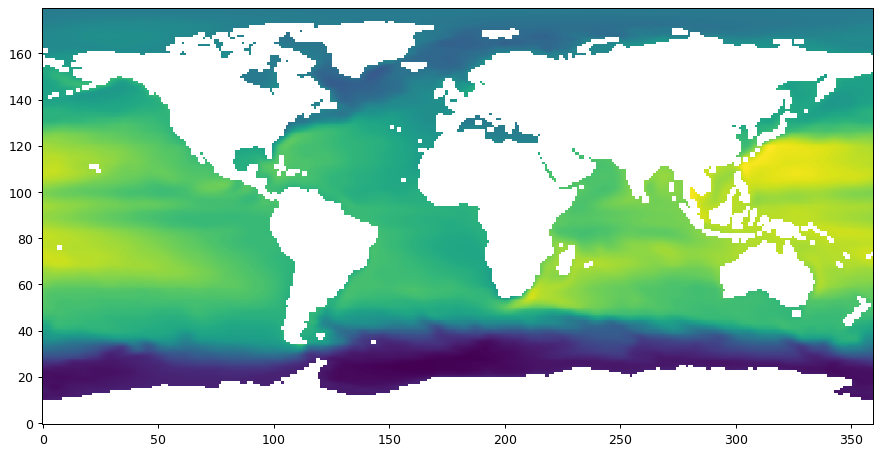

In [13]:
# plot the whole field
plt.figure(figsize=(12,6), dpi= 90)
plt.imshow(field_nearest_1deg,origin='lower')


### Regional

#### 1 degree, nearest neighbor

First we'll interpolate only to a subset of the N. Atlantic at 1 degree.

-89.5 9.5
-90.0 10.0
30.5 81.5
30.0 82.0


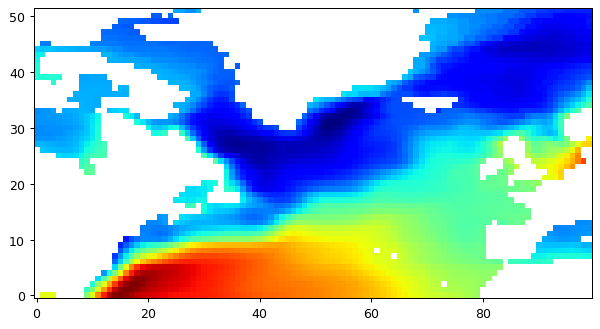

In [14]:
new_grid_delta_lat = 1
new_grid_delta_lon = 1

new_grid_min_lat = 30
new_grid_max_lat = 82

new_grid_min_lon = -90
new_grid_max_lon = 10

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                ecco_ds.SSH.isel(time=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

# plot the whole field, this time land values are nans.
plt.figure(figsize=(8,6), dpi= 90)
plt.imshow(field_nearest_1deg,origin='lower',cmap='jet')

#### 0.05 degree, nearest neighbor

Next we'll interpolate the same domain at a much higher resolution, 0.05 degree:

-89.975 9.975000000000001
-90.0 10.0
30.025 81.975
30.0 82.0


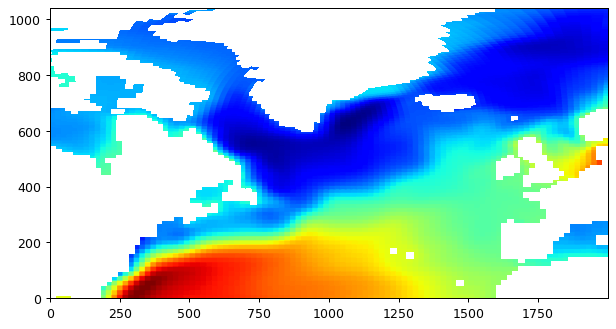

In [15]:
new_grid_delta_lat = 0.05
new_grid_delta_lon = 0.05

new_grid_min_lat = 30
new_grid_max_lat = 82

new_grid_min_lon = -90
new_grid_max_lon = 10


new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                ecco_ds.SSH.isel(time=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

# plot the whole field, this time land values are nans.
plt.figure(figsize=(8,6), dpi= 90)
plt.imshow(field_nearest_1deg,origin='lower',cmap='jet');

The new grid is much finer than the llc90 grid.  Because we are using the nearest neighbor method, you can make out the approximate size and location of the llc90 model grid cells (think about it: nearest neighbor).

#### 0.05 degree, bin average

With bin averaging many values from the source grid are 'binned' together and then averaged to determine the value in the new grid.  The numer of grid cells from the source grid depends on the source grid resolution and the radius of influence.  If we were to choose a radius of influence of 120000 m (a little longer than 1 degree longitude at the equator) the interpolated lat-lon map would be smoother than if we were to choose a smaller radius.  To demonstrate:

bin average with 120000 m radius

-89.975 9.975000000000001
-90.0 10.0
30.025 81.975
30.0 82.0


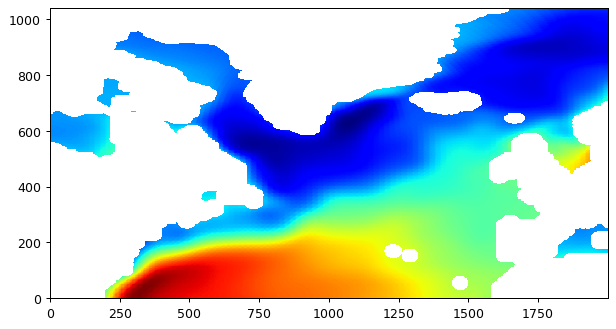

In [16]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                ecco_ds.SSH.isel(time=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'bin_average',
                                radius_of_influence = 120000)

# plot the whole field, this time land values are nans.
plt.figure(figsize=(8,6), dpi= 90)
plt.imshow(field_nearest_1deg,origin='lower',cmap='jet');

bin average with 40000m radius

-89.975 9.975000000000001
-90.0 10.0
30.025 81.975
30.0 82.0


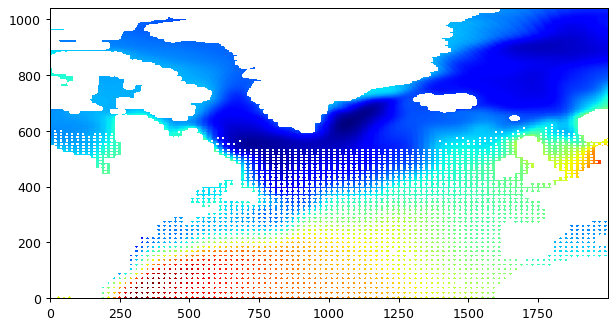

In [17]:
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
field_nearest_1deg =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                ecco_ds.SSH.isel(time=0),\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'bin_average',
                                radius_of_influence = 40000)

# plot the whole field, this time land values are nans.
plt.figure(figsize=(8,6), dpi= 90)
plt.imshow(field_nearest_1deg,origin='lower',cmap='jet');

You may wonder why there are missing (white) values in the resulting map.  It's because there are some lat-lon grid cells whose center is more than 40km away from the center of any grid cell on the source grid. There are ways to get around this problem by specifying spatially-varying radii of influence, but that will have to wait for another tutorial.  

If you want to explore on your own, explore some of the low-level routines of the pyresample package: https://pyresample.readthedocs.io/en/latest/

## Interpolating ECCO vectors fields to lat-lon grids

Vector fields require a few more steps to interpolate to the lat-lon grid. At least if what you want are the zonal and meridional vector components.  Why? Because in the llc90 grid, vector fields like ``UVEL`` and ``VVEL``  are defined with positive in the +x and +y directions of the local coordinate system, respectively. A term like ``oceTAUX`` correponds to ocean wind stress in the +x direction and does not correspond to *zonal* wind stress.  To calculate zonal wind stress we need to rotate the vector from the llc90 x-y grid system to the lat-lon grid.

To demonstrate why rotation is necessary, consider the model field ``oceTAUX`` 

In [18]:
## Load vector fields
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*STRESS*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

pprint(ecco_ds.data_vars)

Data variables:
    CS       (tile, j, i) float32 0.06158 0.06675 0.07293 ... -0.9854 -0.9984
    SN       (tile, j, i) float32 -0.9981 -0.9978 -0.9973 ... -0.1705 -0.05718
    rA       (tile, j, i) float32 3.623e+08 3.633e+08 ... 3.685e+08 3.611e+08
    dxG      (tile, j_g, i) float32 1.558e+04 1.559e+04 ... 2.36e+04 2.314e+04
    dyG      (tile, j, i_g) float32 2.321e+04 2.327e+04 ... 1.56e+04 1.558e+04
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rAz      (tile, j_g, i_g) float32 1.799e+08 1.805e+08 ... 3.642e+08
    dxC      (tile, j, i_g) float32 1.558e+04 1.559e+04 ... 2.387e+04 2.341e+04
    dyC      (tile, j_g, i) float32 1.156e+04 1.159e+04 ... 1.559e+04 1.558e+04
    rAw      (tile, j, i_g) float32 3.617e+08 3.628e+08 ... 3.722e+08 3.648e+08
    rAs      (tile, j_g, i) float32 1.802e+08 1.807e+08 ... 3.678e+08 3.605e+08
    drC      (k_p1) float32 5.0 10.0 10.0 10.0 10.0 ... 399.0 422.0 445.0 228.2
    drF      (k) float32 10.0 10.0 10.0 1

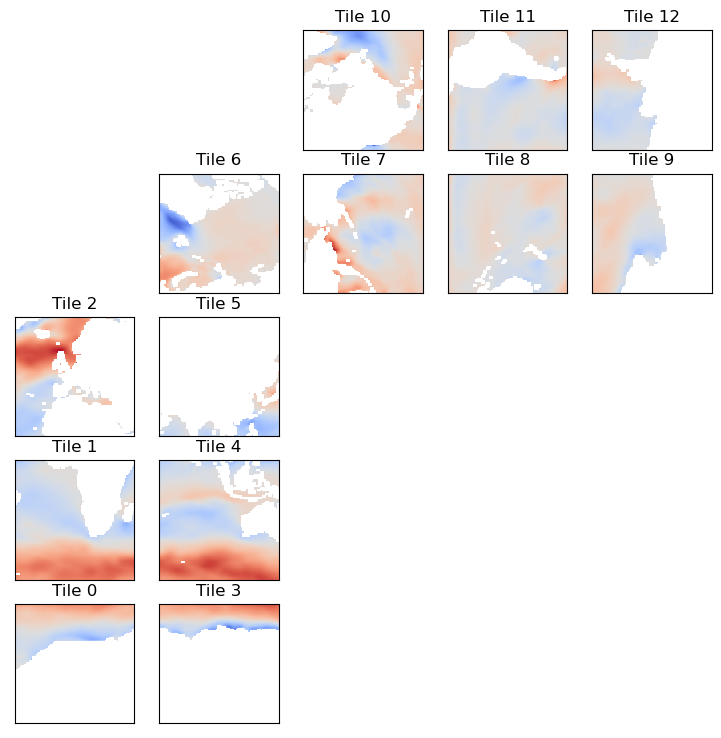

In [19]:
tmp = ecco_ds.oceTAUX.isel(time=0)
ecco.plot_tiles(tmp,cmap='coolwarm');

We can sees the expected positive zonal wind stress in tiles 0-5 because the x-y coordinates of tiles 0-5 happen to approximately line up with the meridians and parallels of the lat-lon grid.  Importantly,  for tiles 7-12 wind stress in the +x direction corresponds to mainly wind stress in the SOUTH direction.  To see the zonal wind stress in tiles 7-12 one has to plot ``oceTAUY`` and recognize that for those tiles positive values correspond with wind stress in the tile's +y direction, which is approximately east-west.  To wit,

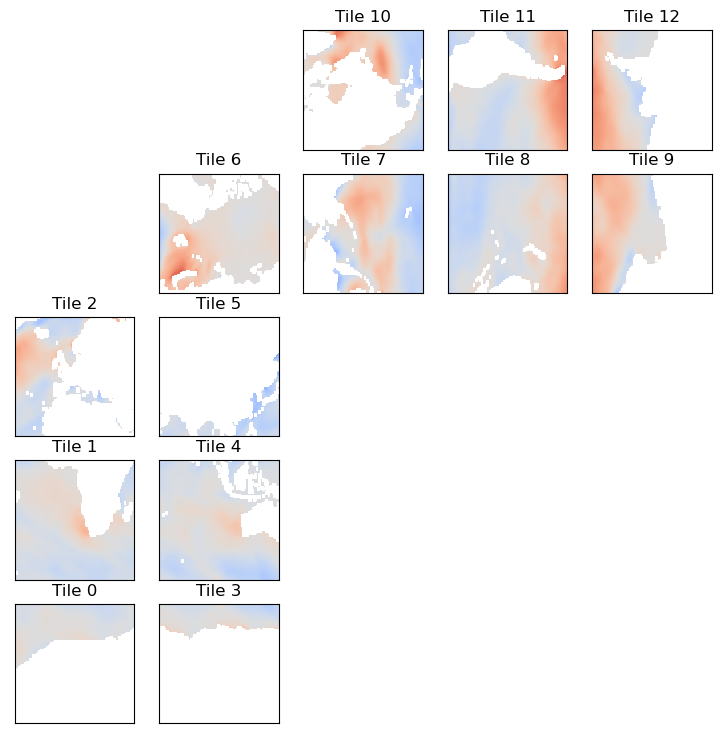

In [20]:
tmp = ecco_ds.oceTAUY.isel(time=0)
ecco.plot_tiles(tmp,cmap='coolwarm');

Great, but if you want zonal and meridional wind stress, we need to determine the zonal and meridional components of these vectors.  

### Vector rotation

For vector rotation we leverage the very useful XGCM package (https://xgcm.readthedocs.io/en/latest/).

> **Note:**  *The XGCM documentation contains an MITgcm ECCOv4 Example Page: https://xgcm.readthedocs.io/en/latest/example_eccov4.html.  In that example the dimension 'tile' is called 'face' and the fields were loaded from the binary output of the MITgcm, not the netCDF files that we produce for the official ECCOv4r4 product.  Differences are largely cosmetic.)*


We use XGCM to map the +x and +y vector components to the grid cell centers from the `u` and `v` grid points of the Arakawa C grid.  The ecco-v4-py routine ``get_llc_grid`` creates the XGCM grid object using a DataSet object containing the following information about the model grid:

```
    i,j,i_g,j_g,k,k_l,k_u,k_p1 .  

```

Our ``ecco_ds`` DataSet does have these fields, they come from the grid file:

In [21]:
# dimensions of the ecco_ds DataSet
ecco_ds.dims

Frozen({'i': 90, 'i_g': 90, 'j': 90, 'j_g': 90, 'k': 50, 'k_u': 50, 'k_l': 50, 'k_p1': 51, 'tile': 13, 'nb': 4, 'nv': 2, 'time': 12})

In [22]:
# Make the XGCM object
XGCM_grid = ecco.get_llc_grid(ecco_ds)

# look at the XGCM object.
XGCM_grid

# Depending on how much you want to geek out, you can learn about this fancy XGCM_grid object here:
# https://xgcm.readthedocs.io/en/latest/grid_topology.html


coords = None


<xgcm.Grid>
Y Axis (not periodic, boundary='fill'):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic, boundary='fill'):
  * center   time
X Axis (not periodic, boundary='fill'):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary='fill'):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center

Once we have the XGCM_grid object, we can use built-in routines of XGCM to interpolate the x and y components of a vector field to the cell centers.

In [23]:
import xgcm
xfld = ecco_ds.oceTAUX.isel(time=0)
yfld = ecco_ds.oceTAUY.isel(time=0)

velc = XGCM_grid.interp_2d_vector({'X': xfld, 'Y': yfld},boundary='fill')

velc is a dictionary of the x and y vector components taken to the model grid cell centers. At this point they are not yet rotated!

In [24]:
velc.keys()

dict_keys(['X', 'Y'])

The magic comes here, with the use of the grid cosine 'cs' and grid  sine 'cs' values from the ECCO grid file:

In [25]:
# Compute the zonal and meridional vector components of oceTAUX and oceTAUY
oceTAU_E  = velc['X']*ecco_ds['CS'] - velc['Y']*ecco_ds['SN']
oceTAU_N  = velc['X']*ecco_ds['SN'] + velc['Y']*ecco_ds['CS']

Now we have the zonal and meridional components of the vectors, albeit still on the llc90 grid.

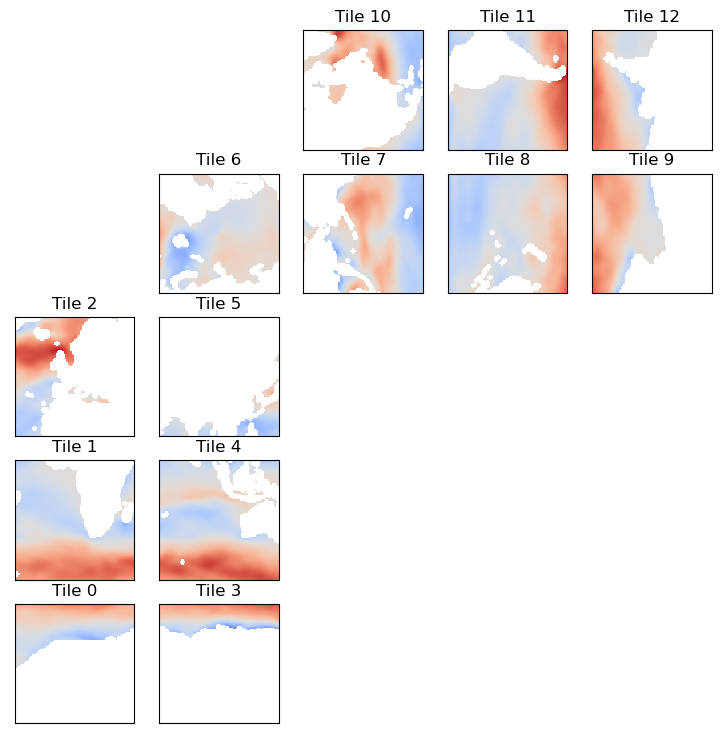

In [26]:
ecco.plot_tiles(oceTAU_E,cmap='coolwarm');

So let's resample ``oceTAU_E`` to a lat-lon grid (that's why you're here, right?) and plot

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


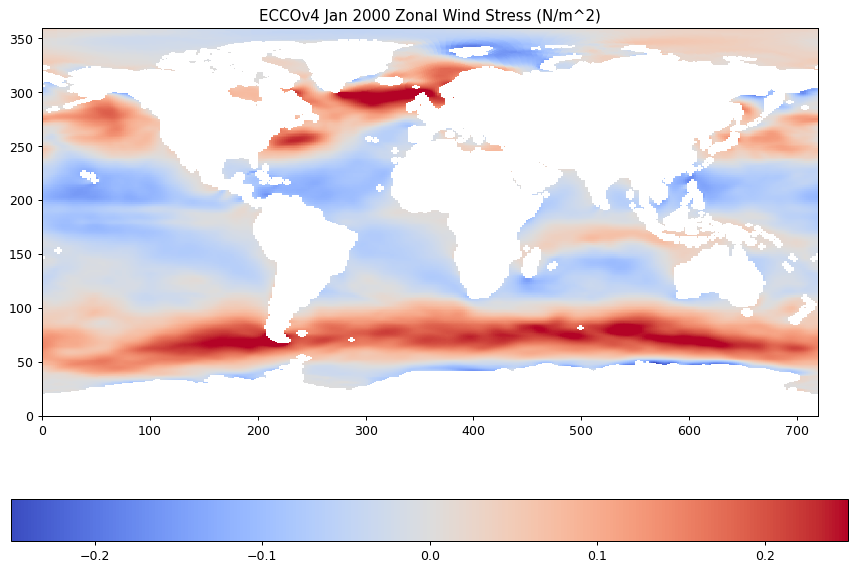

In [27]:
new_grid_delta_lat = .5
new_grid_delta_lon = .5

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180

new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
oceTAU_E_latlon =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                oceTAU_E,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

# plot the resampled field
plt.figure(figsize=(12,8), dpi= 90);
plt.imshow(oceTAU_E_latlon,origin='lower',vmin=-.25,vmax=.25,cmap='coolwarm');
plt.title('ECCOv4 Jan 2000 Zonal Wind Stress (N/m^2)');
plt.colorbar(orientation='horizontal');

Or with extra fanciness:

0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0


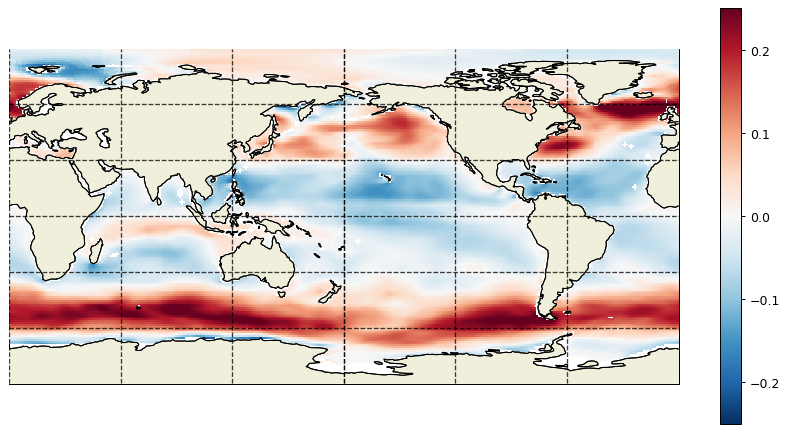

In [28]:
plt.figure(figsize=(12,6), dpi= 90)

ecco.plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, \
                              oceTAU_E, \
                              user_lon_0=180,\
                              projection_type='PlateCarree',\
                              plot_type = 'pcolormesh', \
                              dx=1,dy=1,show_colorbar=True,cmin=-.25, cmax=.25);

Compare vs "The Scatterometer Climatology of Ocean Winds (SCOW)",

https://nanoos.ceoas.oregonstate.edu/scow/index.html

Risien, C.M., and D.B. Chelton, 2008: A Global Climatology of Surface Wind and Wind Stress Fields from Eight Years of QuikSCAT Scatterometer Data. J. Phys. Oceanogr., 38, 2379-2413.

![](https://nanoos.ceoas.oregonstate.edu/scow/figures/January_SCOW_Zonal_Wind_Stress.png)

And of course we can't forget about our meridional wind stress:

0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0


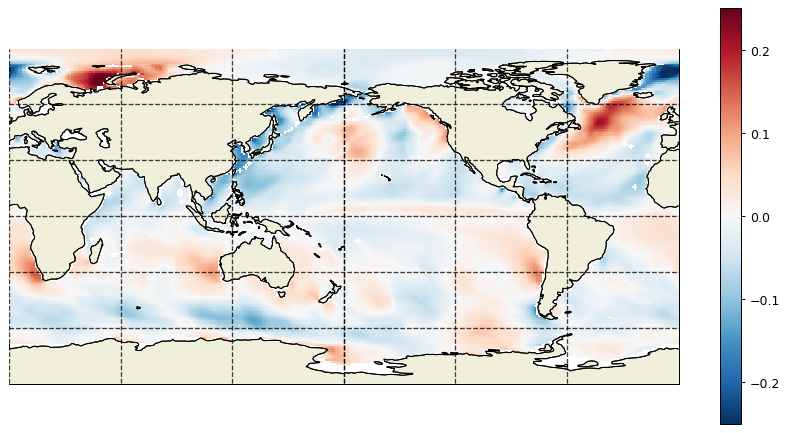

In [29]:
plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_ds.XC, ecco_ds.YC, \
                              oceTAU_N, \
                              user_lon_0=180,\
                              projection_type='PlateCarree',\
                              plot_type = 'pcolormesh', \
                              dx=1,dy=1,cmin=-.25, cmax=.25,show_colorbar=True);

Which we also compare against SCOW:

![](https://nanoos.ceoas.oregonstate.edu/scow/figures/January_SCOW_Meridional_Wind_Stress.png)

### ``UEVNfromUXVY``

The ecco-v4-py library includes a routine, ``UEVNfromUXVY`` which does the interpolation to the grid cell centers and the rotation in one call:

In [30]:
xfld = ecco_ds.oceTAUX.isel(time=0)
yfld = ecco_ds.oceTAUY.isel(time=0)

# Compute the zonal and meridional vector components of oceTAUX and oceTAUY
oceTAU_E, oceTAU_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)

coords = None


Now plot to verify

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


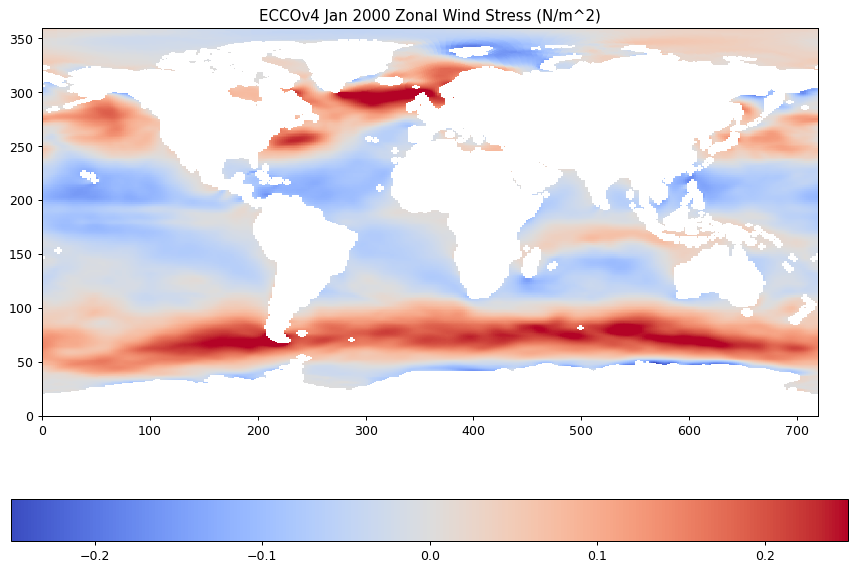

In [31]:
# interpolate to lat-lon
new_grid_lon_centers, new_grid_lat_centers,\
new_grid_lon_edges, new_grid_lat_edges,\
oceTAU_E_latlon =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                oceTAU_E,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

# plot the whole field, this time land values are nans.
plt.figure(figsize=(12,8), dpi= 90);
plt.imshow(oceTAU_E_latlon,origin='lower',vmin=-.25,vmax=.25,cmap='coolwarm');
plt.title('ECCOv4 Jan 2000 Zonal Wind Stress (N/m^2)');
plt.colorbar(orientation='horizontal');

## Saving interpolated fields to netCDF

For this demonstration we will rotate the 12 monthly-mean records of oceTAUX and oceTAUY to their zonal and meridional components, interpolate to a lat-lon grids, and then save the output as netCDF format.


In [32]:
pprint(ecco_ds.oceTAUX.time)

<xarray.DataArray 'time' (time: 12)>
array(['2000-01-16T12:00:00.000000000', '2000-02-15T12:00:00.000000000',
       '2000-03-16T12:00:00.000000000', '2000-04-16T00:00:00.000000000',
       '2000-05-16T12:00:00.000000000', '2000-06-16T00:00:00.000000000',
       '2000-07-16T12:00:00.000000000', '2000-08-16T12:00:00.000000000',
       '2000-09-16T00:00:00.000000000', '2000-10-16T12:00:00.000000000',
       '2000-11-16T00:00:00.000000000', '2000-12-16T12:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2000-12-16T12:00:00
Attributes:
    long_name:              center time of averaging period
    axis:                   T
    bounds:                 time_bnds
    coverage_content_type:  coordinate
    standard_name:          time


We will loop through each month, use ``UEVNfromUXVY`` to determine the zonal and meridional components of the ocean wind stress vectors, and then interpolate to a 0.5 degree lat-lon grid.

In [33]:
oceTAUE = np.zeros((12,360,720))
oceTAUN = np.zeros((12,360,720))

new_grid_delta_lat = .5
new_grid_delta_lon = .5

new_grid_min_lat = -90
new_grid_max_lat = 90

new_grid_min_lon = -180
new_grid_max_lon = 180


for m in range(12):
    cur_oceTAUX = ecco_ds.oceTAUX.isel(time=m)
    cur_oceTAUY = ecco_ds.oceTAUY.isel(time=m)

    # Compute the zonal and meridional vector components of oceTAUX and oceTAUY
    tmp_e, tmp_n  = ecco.vector_calc.UEVNfromUXVY(cur_oceTAUX, cur_oceTAUY, ecco_ds)

    # zonal component
    new_grid_lon_centers, new_grid_lat_centers,\
    new_grid_lon_edges, new_grid_lat_edges,\
    tmp_e_latlon =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                tmp_e,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)
    
    # meridional component
    new_grid_lon_centers, new_grid_lat_centers,\
    new_grid_lon_edges, new_grid_lat_edges,\
    tmp_n_latlon =\
        ecco.resample_to_latlon(ecco_ds.XC, \
                                ecco_ds.YC, \
                                tmp_n,\
                                new_grid_min_lat, new_grid_max_lat, new_grid_delta_lat,\
                                new_grid_min_lon, new_grid_max_lon, new_grid_delta_lon,\
                                fill_value = np.NaN, \
                                mapping_method = 'nearest_neighbor',
                                radius_of_influence = 120000)

    oceTAUE[m,:] = tmp_e_latlon
    oceTAUN[m,:] = tmp_n_latlon

coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0
coords = None
-179.75 179.75
-180.0 180.0
-89.75 89.75
-

In [34]:
# make the new data array structures for the zonal and meridional wind stress fields
oceTAUE_DA = xr.DataArray(oceTAUE,  name = 'oceTAUE', 
                      dims = ['time','latitude','longitude'], 
                      coords = {'latitude': new_grid_lat_centers[:,0],
                                'longitude': new_grid_lon_centers[0,:],
                                'time': ecco_ds.time})

# make the new data array structures for the zonal and meridional wind stress fields
oceTAUN_DA = xr.DataArray(oceTAUN,  name = 'oceTAUN', 
                      dims = ['time','latitude','longitude'], 
                      coords = {'latitude': new_grid_lat_centers[:,0],
                                'longitude': new_grid_lon_centers[0,:],
                                'time': ecco_ds.time})

Plot the zonal and meridional wind stresses in these new DataArray objects:

In [35]:
oceTAUE_DA.dims     

('time', 'latitude', 'longitude')

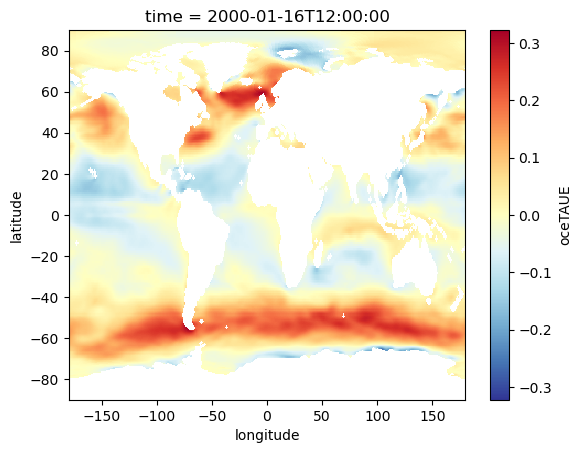

In [36]:
oceTAUE_DA.isel(time=0).plot(cmap='RdYlBu_r')

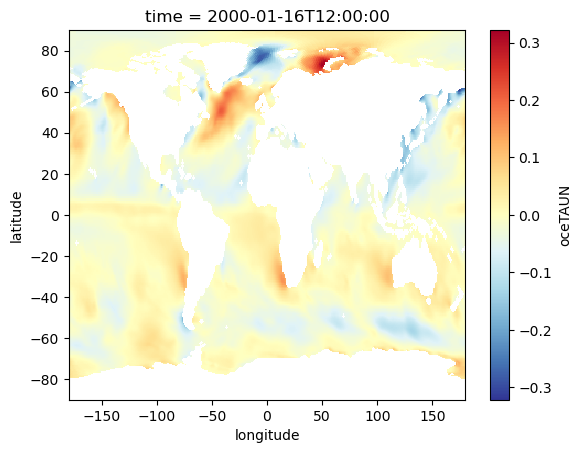

In [37]:
oceTAUN_DA.isel(time=0).plot(cmap='RdYlBu_r')

### Saving is easy with xarray


In [38]:
# meridional component
output_path = join(user_home_dir,'Downloads','oceTAUN_latlon_2000.nc')
oceTAUN_DA.to_netcdf(output_path)

# zonal component
output_path = join(user_home_dir,'Downloads','oceTAUE_latlon_2000.nc')
oceTAUE_DA.to_netcdf(output_path)

... done!